## Imports

In [1]:
# Modules
# %matplotlib inline  
#%matplotlib nbagg
#%matplotlib notebook


import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objs as go
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as stt
import os
import shutil
import sklearn
from sklearn import preprocessing
import logging
import itertools

# Tensorflow
import tensorflow as tf
# Disable tf logger
tf.logging.set_verbosity(tf.logging.WARN)

# Pyplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Matplotlib
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Customed logger
logger = logging.getLogger('bitcoin')
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s', datefmt='%m-%d %H:%M')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [2]:
import quandl
quandl.ApiConfig.api_key = 'CHUd6-4cEE_zT5VHhX4A'

In [3]:
btc = quandl.get('BITFINEX/BTCUSD')
info = quandl.get('BITCOINWATCH/MINING')
eth = quandl.get('BITFINEX/ETHUSD')
ltc = quandl.get('BITFINEX/LTCUSD')
bch = quandl.get('BITFINEX/BCHUSD')
xrp = quandl.get('BITFINEX/XRPUSD')

print(btc.shape)

(1882, 7)


In [4]:
btc.describe()

,High,Low,Mid,Last,Bid,Ask,Volume
count,1882.000000,1882.000000,1872.000000,1882.000000,1872.000000,1872.000000,1882.000000
mean,3107.008709,2890.913322,3021.527629,3010.296414,3021.235765,3021.819493,26408.586429
std,3760.886571,3425.004967,3617.347551,3610.954249,3617.107165,3617.588071,26374.888911
min,0.000000,0.000000,177.980000,178.000000,177.960000,178.000000,0.000000
25%,416.415000,395.472500,408.155000,409.117500,408.077500,408.257500,9439.022035
50%,766.425000,735.000000,753.067500,754.665000,753.035000,753.100000,18365.557123
75%,5554.925000,5305.425000,5481.587500,5447.250000,5481.175000,5482.000000,34238.425376
max,19891.000000,18622.000000,19209.000000,19210.000000,19208.000000,19210.000000,269676.763207


In [5]:
info.columns = [c.replace(' ', '_') for c in info.columns]
info.describe()

,Total_BTC,Market_Cap,Transactions_last_24h,Transactions_avg._per_hour,Bitcoins_sent_last_24h,Bitcoins_sent_avg._per_hour,Count,Blocks_last_24h,Blocks_avg._per_hour,Difficulty,Next_Difficulty,Network_Hashrate_Terahashs,Network_Hashrate_PetaFLOPS
count,2.000000e+03,2.000000e+03,1212.000000,1212.000000,1.212000e+03,1.212000e+03,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,1.517227e+07,4.770591e+10,152519.490924,6354.979579,1.802472e+06,7.510299e+04,410567.843000,93.833500,3.910145,4.305396e+11,4.211036e+11,3.014379e+06,3.828261e+07
std,1.552152e+06,5.992405e+10,88570.085157,3690.420212,2.569819e+06,1.070758e+05,73997.319519,77.542615,3.231260,3.970332e+11,3.821442e+11,2.735496e+06,3.474080e+07
min,1.160878e+07,1.342254e+09,1407.000000,58.630000,1.395002e+04,5.812500e+02,254350.000000,0.000000,0.000000,6.575006e+07,6.849834e+07,4.903300e+02,6.227190e+03
25%,1.388062e+07,5.830387e+09,71802.500000,2991.767500,7.857671e+05,3.274029e+04,345223.750000,0.000000,0.000000,4.668438e+10,4.664003e+10,3.338624e+05,4.240052e+06
50%,1.587306e+07,1.108686e+10,115395.000000,4808.125000,1.310239e+06,5.459329e+04,429844.000000,138.000000,5.750000,2.258329e+11,2.337171e+11,1.673012e+06,2.124725e+07
75%,1.652280e+07,8.456906e+10,228695.750000,9528.992500,2.263041e+06,9.429339e+04,481823.000000,157.000000,6.540000,9.232331e+11,8.877369e+11,6.354669e+06,8.070429e+07
max,1.652280e+07,3.172873e+11,372103.000000,15504.290000,6.735430e+07,2.806429e+06,481823.000000,257.000000,10.710000,9.232331e+11,9.316186e+11,6.668786e+06,8.469358e+07


## Loading data (alt)

In [ ]:
# Download data from various sources. Note that iloc reverses the df, 
# so that recent data are on bottom

# api key: CHUd6-4cEE_zT5VHhX4A

# Crypto time series
btc = web.DataReader('BITFINEX/BTCUSD', 'quandl', '2019-01-01', '2019-01-06').iloc[::-1]
eth = web.DataReader('BITFINEX/ETHUSD', 'quandl').iloc[::-1]
ltc = web.DataReader('BITFINEX/LTCUSD', 'quandl').iloc[::-1]
bch = web.DataReader('BITFINEX/BCHUSD', 'quandl').iloc[::-1]
xrp = web.DataReader('BITFINEX/XRPUSD', 'quandl').iloc[::-1]

# Bitcoin generic info dataset
info = web.DataReader('BITCOINWATCH/MINING', 'quandl').iloc[::-1]

In [7]:
btc.describe()

,High,Low,Mid,Last,Bid,Ask,Volume
count,1882.000000,1882.000000,1872.000000,1882.000000,1872.000000,1872.000000,1882.000000
mean,3107.008709,2890.913322,3021.527629,3010.296414,3021.235765,3021.819493,26408.586429
std,3760.886571,3425.004967,3617.347551,3610.954249,3617.107165,3617.588071,26374.888911
min,0.000000,0.000000,177.980000,178.000000,177.960000,178.000000,0.000000
25%,416.415000,395.472500,408.155000,409.117500,408.077500,408.257500,9439.022035
50%,766.425000,735.000000,753.067500,754.665000,753.035000,753.100000,18365.557123
75%,5554.925000,5305.425000,5481.587500,5447.250000,5481.175000,5482.000000,34238.425376
max,19891.000000,18622.000000,19209.000000,19210.000000,19208.000000,19210.000000,269676.763207


In [8]:
info.describe()

,Total_BTC,Market_Cap,Transactions_last_24h,Transactions_avg._per_hour,Bitcoins_sent_last_24h,Bitcoins_sent_avg._per_hour,Count,Blocks_last_24h,Blocks_avg._per_hour,Difficulty,Next_Difficulty,Network_Hashrate_Terahashs,Network_Hashrate_PetaFLOPS
count,2.000000e+03,2.000000e+03,1212.000000,1212.000000,1.212000e+03,1.212000e+03,2000.000000,2000.000000,2000.000000,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,1.517227e+07,4.770591e+10,152519.490924,6354.979579,1.802472e+06,7.510299e+04,410567.843000,93.833500,3.910145,4.305396e+11,4.211036e+11,3.014379e+06,3.828261e+07
std,1.552152e+06,5.992405e+10,88570.085157,3690.420212,2.569819e+06,1.070758e+05,73997.319519,77.542615,3.231260,3.970332e+11,3.821442e+11,2.735496e+06,3.474080e+07
min,1.160878e+07,1.342254e+09,1407.000000,58.630000,1.395002e+04,5.812500e+02,254350.000000,0.000000,0.000000,6.575006e+07,6.849834e+07,4.903300e+02,6.227190e+03
25%,1.388062e+07,5.830387e+09,71802.500000,2991.767500,7.857671e+05,3.274029e+04,345223.750000,0.000000,0.000000,4.668438e+10,4.664003e+10,3.338624e+05,4.240052e+06
50%,1.587306e+07,1.108686e+10,115395.000000,4808.125000,1.310239e+06,5.459329e+04,429844.000000,138.000000,5.750000,2.258329e+11,2.337171e+11,1.673012e+06,2.124725e+07
75%,1.652280e+07,8.456906e+10,228695.750000,9528.992500,2.263041e+06,9.429339e+04,481823.000000,157.000000,6.540000,9.232331e+11,8.877369e+11,6.354669e+06,8.070429e+07
max,1.652280e+07,3.172873e+11,372103.000000,15504.290000,6.735430e+07,2.806429e+06,481823.000000,257.000000,10.710000,9.232331e+11,9.316186e+11,6.668786e+06,8.469358e+07


In [9]:
# Select features to be used in prediction
features = {'ltc_Mid': ltc.Mid, 'btc_Mid': btc.Mid, 'btc_Volume': btc.Volume, 'info_MarketCap': info.Market_Cap }

## Plot

In [10]:
data = []
d = {}
for ind, (key, value) in enumerate(features.items()):
    # Create trace to add to data
    trace = go.Scatter(x=value.index, y=value, name=key, yaxis='y{}'.format(ind+1))
    data.append(trace)
    # Create dictionaries for layout
    d['yaxis{}'.format(ind+2)] = {'overlaying': 'y', 'side': 'left'}
fig = go.Figure(data=data, layout=d)
iplot(fig)

In [11]:
# Construct the dataframe containing selected features
tms = pd.DataFrame(index = btc.index)
for key, values in features.items():
    tms[key] = values
logger.info('Shape of tms %s', tms.shape)
tms = tms.dropna()
logger.info('Shape of tms after filtering not NaNs rows %s', tms.shape)
tms_filtered = tms.copy()

07-26 10:29 bitcoin      INFO     Shape of tms (1882, 4)
07-26 10:29 bitcoin      INFO     Shape of tms after filtering not NaNs rows (1750, 4)


## Process the input

In [12]:
# Create the input to be provided to the LSTM network
def sentences_generator(sequence, seq_len = 40, step=1):
    sentences = []
    next_tokens = []
    for i in range(0, len(sequence) - seq_len, step):
        sentences.append(sequence[i: i + seq_len])
        next_tokens.append(sequence[i + seq_len])
    logger.info('Sequence length: %s' % len(sentences))
    logger.info('Next token length: %s' % len(sentences))
    return np.array(sentences), np.array(next_tokens)

# Normalize the data
def normalize(data, regressors, kind = 'min_max'):
    scalers = []
    for el in regressors:
        if kind == 'min_max':
            scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))
        elif kind == 'standard':
            scaler = sklearn.preprocessing.StandardScaler()
        data[el] = scaler.fit_transform(data[el].values.reshape(-1,1))
        scalers.append(scaler)
    return data, scalers

# Permutate the input sequences
def permutate_sequences(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Normalizing data

In [13]:
tms, scaler = normalize(tms.copy(), tms.columns)

### Creating sequences

In [14]:
# Number of previous timesteps to consider in predictions
timesteps = 10

In [15]:
# Create seguences which can be feeded to the TF LSTM 
sequences, next_tokens = sentences_generator(tms.values, seq_len = timesteps)
# Keep track of original dates
dates = tms_filtered.index[timesteps:]

07-26 10:29 bitcoin      INFO     Sequence length: 1740
07-26 10:29 bitcoin      INFO     Next token length: 1740


### Create train, validation and test datasets

In [16]:
# Sequence splitting
test_split = int(len(sequences)*.90)
val_split = int(len(sequences)*.75)
train_sequences, train_next_tokens = sequences[:val_split], next_tokens[:val_split]
val_sequences, val_next_tokens = sequences[val_split:test_split], next_tokens[val_split:test_split]
test_sequences, test_next_tokens = sequences[test_split:], next_tokens[test_split:]
train_dates, val_dates, test_dates = dates[:val_split], dates[val_split:test_split], dates[test_split:]

## Model

### Define network parameters

In [17]:
# Reset the graph
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.001
num_epoch = 1000
batch_size = 128
display_meas_step = 20
save_model_step = 50

# Network Parameters
# Number of features
num_input = len(features)
# Number of features yielded from LSTM hidden layer
num_hidden_rnn = 256
# Number of features yielded from first ANN layer
num_hidden_nn = 32
# Number of output features
num_output = len(features)

# TF inputs
X = tf.placeholder("float", [None, timesteps, num_input], name = 'X')
Y = tf.placeholder("float", [None, num_output], name = 'Y')

### Define the model model

In [18]:
# Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
with tf.name_scope('input'):
    x = tf.unstack(X, timesteps, axis = 1)
with tf.name_scope('rnn'):
    # Define a lstm cell
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden_rnn, forget_bias=1.0)
    # Get LSTM cell outputs and states
    rnn_outputs, rnn_states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    # For tensorboard
    rnn_weights = lstm_cell.weights[0]
    rnn_biases = lstm_cell.weights[1]
    tf.summary.histogram("outputs", rnn_outputs)
    tf.summary.histogram("states", rnn_states)
    tf.summary.histogram("rnn_weights", rnn_weights)
    tf.summary.histogram("rnn_biases", rnn_biases)
with tf.name_scope('nn'):
    # Define the first ANN
    nn_outputs = tf.layers.dense(rnn_outputs[-1], num_hidden_nn, activation=tf.nn.tanh, name = 'nn1')
    # Define the second ANN
    prediction = tf.layers.dense(nn_outputs, num_output, name = 'nn2')
    # For tensorboard
    with tf.variable_scope("nn1", reuse=True):
        nn1_weights = tf.get_variable('kernel')
        nn1_biases = tf.get_variable('bias')
    with tf.variable_scope("nn2", reuse=True):
        nn2_weights = tf.get_variable('kernel')
        nn2_biases = tf.get_variable('bias')
    tf.summary.histogram("nn1_weights", nn1_weights)
    tf.summary.histogram("nn1_biases", nn1_biases)
    tf.summary.histogram("nn2_weights", nn2_weights)
    tf.summary.histogram("nn2_biases", nn2_biases)
    tf.summary.histogram("train_prediction", prediction)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [19]:
# Loss
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.square(prediction - Y), name = 'loss')
    train_loss_summ = tf.summary.scalar('train_loss', loss, collections = 'evaluation')
    val_loss_summ = tf.summary.scalar('val_loss', loss, collections = 'evaluation')
# Optimizer
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate, name = 'optimizer')
# Minimize
with tf.name_scope('train'):
    minimize = optimizer.minimize(loss, name = 'minimize')

### Training

In [20]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
# Select a directory where saving the results
base_dir = './rnn'
file_writer_dir = '{}/run1/logs'.format(base_dir)
save_model_dir = '{}/run1/model'.format(base_dir)
# Delete the directory if existing
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

In [ ]:
try:
    with tf.Session() as sess:
        # Run the initializer
        sess.run(init)
        # Merge all the summaries (except those having no default 'collections')
        merged_summary = tf.summary.merge_all()
        # Write the summary handler for tensorboard
        writer = tf.summary.FileWriter(file_writer_dir)
        writer.add_graph(sess.graph)
        
        # Training
        for epoch in range(1, num_epoch+1):
            for start in range(0, len(train_sequences) + 1, batch_size):
                logger.debug('Taking batch from {} to {}'.format(start, min(start+batch_size, len(train_sequences))))
                # Create training batches
                batch_x = train_sequences[start:min(start+batch_size, len(train_sequences))]
                batch_y = train_next_tokens[start:min(start+batch_size, len(train_next_tokens))]
                
                # Shuffle data at each epoch 
                batch_x, batch_y = permutate_sequences(batch_x, batch_y)
                
                # Run optimization operation (backprop)
                sess.run(minimize, feed_dict={X: batch_x, Y: batch_y})
            # Execute all the summaries
            summ = sess.run(merged_summary, feed_dict={X: batch_x, Y: batch_y})
            writer.add_summary(summ, epoch)
            if epoch % display_meas_step == 0 or epoch == 1:
                # Calculate batch loss and accuracy
                train_loss, train_prediction, train_summ = sess.run([loss, prediction, train_loss_summ], 
                                                           feed_dict={X: train_sequences, Y: train_next_tokens})
                val_loss, val_prediction, val_summ = sess.run([loss, prediction, val_loss_summ], 
                                                       feed_dict={X: val_sequences, Y: val_next_tokens})
                # Execute the summaries having no default 'collections'
                writer.add_summary(train_summ, epoch)
                writer.add_summary(val_summ, epoch)
                logger.info("Epoch {}, minibatch training loss={:.6f}, val loss={:.6f}".
                             format(str(epoch), train_loss, val_loss))
            if epoch % save_model_step == 0 or epoch == 1:
                # Save the model
                logger.info('Saving the model')
                tf.saved_model.simple_save(sess,
                                           '{}/epoch{}'.format(save_model_dir, epoch),
                                           inputs={"x": X},
                                           outputs={"y": Y})
        logger.info("Optimization Finished!")
except KeyboardInterrupt as e:
    logger.warning('Execution interrupted')

07-26 10:30 bitcoin      INFO     Epoch 1, minibatch training loss=0.045826, val loss=0.064491
07-26 10:30 bitcoin      INFO     Saving the model


Instructions for updating:
Pass your op to the equivalent parameter main_op instead.


07-26 10:30 bitcoin      INFO     Epoch 20, minibatch training loss=0.017848, val loss=0.012342
07-26 10:30 bitcoin      INFO     Epoch 40, minibatch training loss=0.010964, val loss=0.008990
07-26 10:30 bitcoin      INFO     Saving the model
07-26 10:30 bitcoin      INFO     Epoch 60, minibatch training loss=0.010606, val loss=0.007936
07-26 10:30 bitcoin      INFO     Epoch 80, minibatch training loss=0.013511, val loss=0.007405
07-26 10:30 bitcoin      INFO     Epoch 100, minibatch training loss=0.010173, val loss=0.007453
07-26 10:30 bitcoin      INFO     Saving the model
07-26 10:31 bitcoin      INFO     Epoch 120, minibatch training loss=0.009640, val loss=0.011283
07-26 10:31 bitcoin      INFO     Epoch 140, minibatch training loss=0.009706, val loss=0.011846
07-26 10:31 bitcoin      INFO     Saving the model
07-26 10:31 bitcoin      INFO     Epoch 160, minibatch training loss=0.008979, val loss=0.024154
07-26 10:31 bitcoin      INFO     Epoch 180, minibatch training loss=0.0098

## Evaluate the model

### Predicting  
#### I:\Planzeit_KI\_TestUmgebung\Georg\bitcoin-master\rnn\run1\logs

In [46]:
# Specify the model to use for predictions
checkpoint_epoch = 150
graph = tf.Graph()
# Define the number of days ahead for which performing predictions
ahead_steps = 30
# Define those starting points from which beginning ahead predictions
startings = [x for x in range(0, len(sequences), 40)] + [len(sequences)-1]
with graph.as_default():
    with tf.Session(graph=graph) as sess:
        # Restore saved model
        logger.info('Restoring...')
        tf.saved_model.loader.load(sess, 
                                   [tf.saved_model.tag_constants.SERVING], 
                                   '{}/epoch{}'.format(save_model_dir, checkpoint_epoch))
        logger.info('Restored...')
        # Restore saved values
        X = graph.get_tensor_by_name("X:0")
        Y = graph.get_tensor_by_name("Y:0")
        prediction = graph.get_tensor_by_name('nn/nn2/BiasAdd:0')
        loss = graph.get_tensor_by_name('loss/loss:0')
        # Predictions for training, validation and test
        train_loss, train_prediction = sess.run([loss, prediction], feed_dict={X: train_sequences, 
                                                                         Y: train_next_tokens})
        val_loss, val_prediction = sess.run([loss, prediction], feed_dict={X: val_sequences, 
                                                                     Y: val_next_tokens})
        test_loss, test_prediction = sess.run([loss, prediction], feed_dict={X: test_sequences, 
                                                                       Y: test_next_tokens})

        # Predict next element and progressively shifting predictions
        all_ahead_prediction, all_ahead_dates = [], []
        for starting in startings:
            ahead_sequences = np.expand_dims(sequences[starting], axis = 0)
            ahead_next_tokens = np.expand_dims(next_tokens[starting], axis = 0)
            ahead_prediction = []
            for ah_step in range(ahead_steps):
                pred = sess.run([prediction], feed_dict = {X: ahead_sequences})
                ahead_sequences = np.concatenate((ahead_sequences[:, 1:, :], pred), axis = 1)
                ahead_prediction.append(pred[0][0])
            ahead_prediction = np.array(ahead_prediction)
            all_ahead_prediction.append(ahead_prediction)

07-26 09:58 bitcoin      INFO     Restoring...
07-26 09:58 bitcoin      INFO     Restored...


In [47]:
# Create dataframes containing predictions for 
# training, validation and test
train_preds = pd.DataFrame({'set': 'training'}, index = tms_filtered.loc[train_dates].index)
val_preds = pd.DataFrame({'set': 'validation'}, index = tms_filtered.loc[val_dates].index)
test_preds = pd.DataFrame({'set': 'test'}, index = tms_filtered.loc[test_dates].index)
for i, el in enumerate(tms_filtered.columns):
    rebuilt_train = scaler[i].inverse_transform(train_prediction[:, i].reshape(-1, 1)).squeeze()
    train_preds['transf_preds_%s' % el] = train_prediction[:, i]
    train_preds['preds_%s' % el] = rebuilt_train
    rebuilt_val = scaler[i].inverse_transform(val_prediction[:, i].reshape(-1, 1)).squeeze()
    val_preds['transf_preds_%s' % el] = val_prediction[:, i]
    val_preds['preds_%s' % el] = rebuilt_val
    rebuilt_test = scaler[i].inverse_transform(test_prediction[:, i].reshape(-1, 1)).squeeze()
    test_preds['transf_preds_%s' % el] = test_prediction[:, i]
    test_preds['preds_%s' % el] = rebuilt_test

# Create dataframe containing ahead predictions
all_ahead_preds = []
for starting, ahead_prediction in zip(startings, all_ahead_prediction):
    ahead_preds = pd.DataFrame(index = pd.date_range(dates[starting],
                                                     periods=ahead_steps, freq='D'))
    for i, el in enumerate(tms.columns):
        rebuilt_ahead = scaler[i].inverse_transform(ahead_prediction[:, i].reshape(-1, 1)).squeeze()
        ahead_preds['transf_preds_%s' % el] = ahead_prediction[:, i]
        ahead_preds['preds_%s' % el] = rebuilt_ahead

    all_ahead_preds.append(ahead_preds)
     
# Sort dataframe
train_preds = train_preds.sort_index()
val_preds = val_preds.sort_index()
test_preds = test_preds.sort_index()

### Plot predictions

In [50]:
for el in tms_filtered.columns:
    # Trace for training
    training = go.Scatter(
        x = train_preds.index,
        y = train_preds['preds_%s' % el],
        name = 'Training %s' % el
    )
    # Trace for validation
    validation = go.Scatter(
        x = val_preds.index,
        y = val_preds['preds_%s' % el],
        name = 'Validation %s' % el
    )
    # Trace for test
    test = go.Scatter(
        x = test_preds.index,
        y = test_preds['preds_%s' % el],
        name = 'Test %s' % el
    )
    # Trace for ground truth
    ground_truth = go.Scatter(
        x = tms_filtered.index,
        y = tms_filtered[el],
        name = 'Ground truth %s' % el,  
    )
    # Trace for ahead predictions
    aheads = []
    for ahead_preds in all_ahead_preds:
        ahead = go.Scatter(
            x = ahead_preds.index,
            y = ahead_preds['preds_%s' % el],
            showlegend=False,
            marker = dict(color = 'rgba(80, 26, 80, 0.8)')
        )
        aheads.append(ahead)
    data = [training, validation, test, ground_truth] + aheads
    layout = go.Layout(
        title = 'Predictions %s ' % el,
        yaxis = dict(title = 'Last')
    )
    fig = go.Figure(data = data, layout = layout)
    iplot(fig)

0.00    6.553854e+09
0.50    2.044690e+10
0.75    1.025029e+11
0.90    1.408915e+11
0.95    1.687176e+11
1.00    3.091952e+11
Name: error, dtype: float64

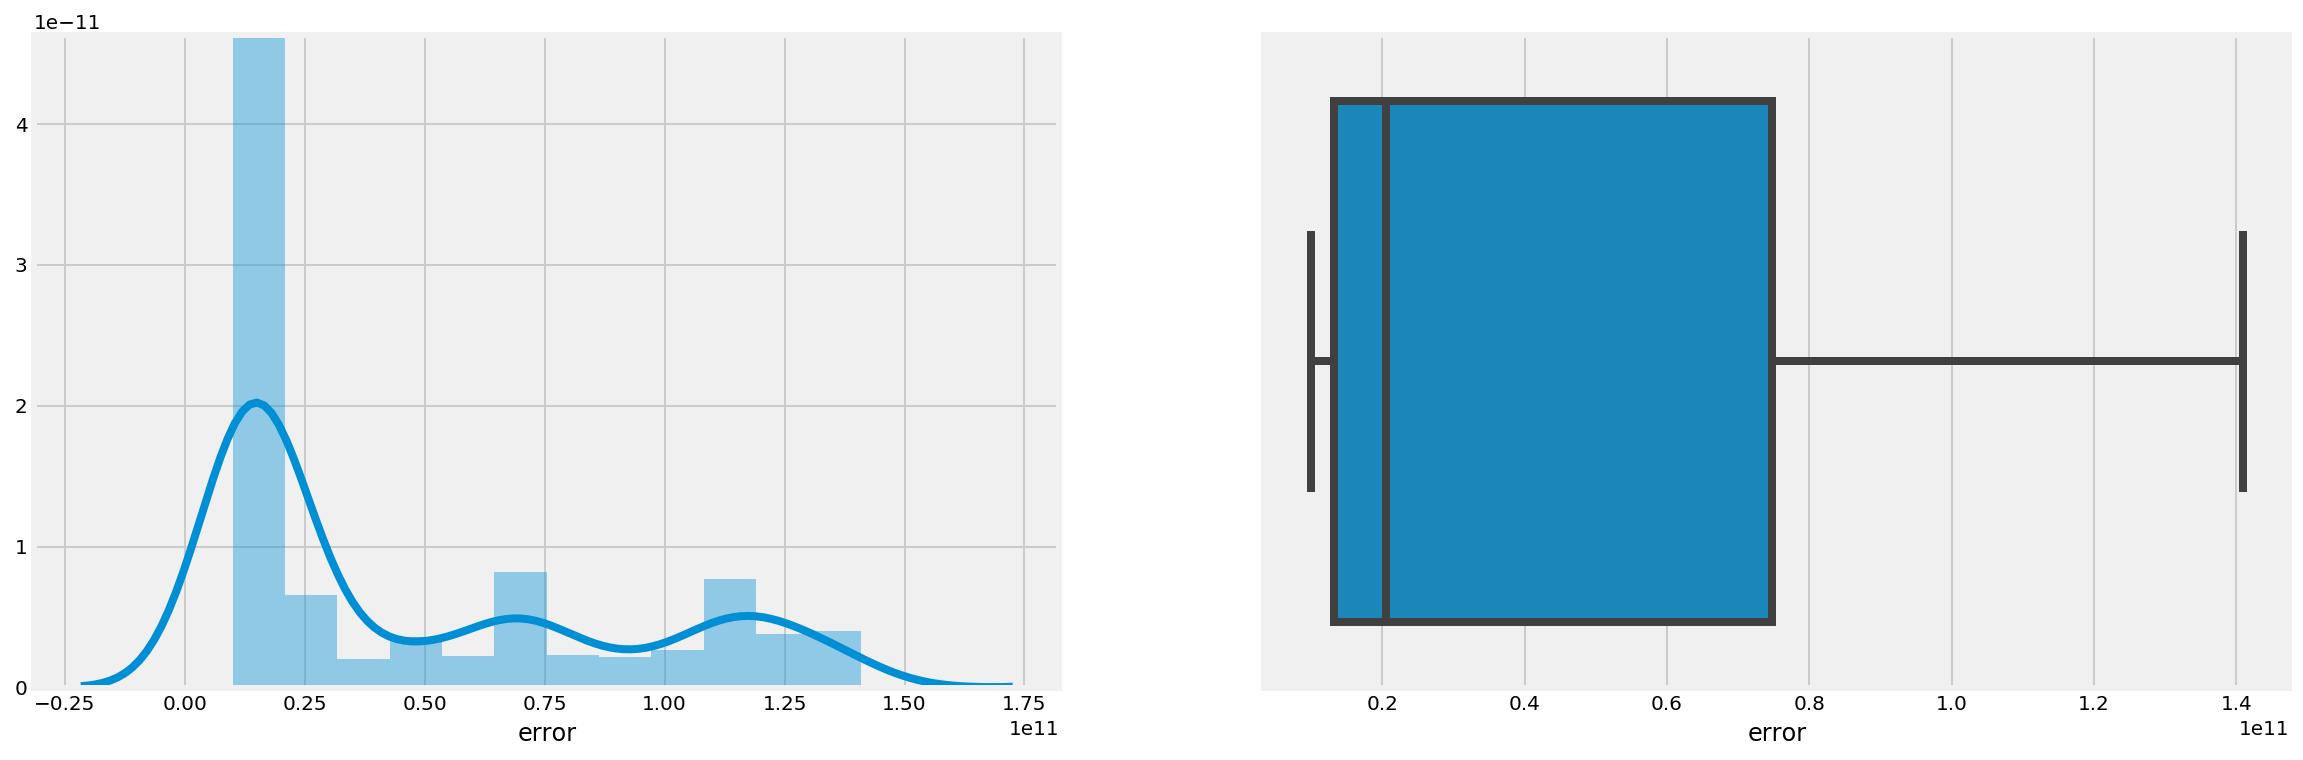

In [49]:
# Aggregate the prediction dataframes
preds = pd.concat([train_preds, val_preds, test_preds])
for el in tms.columns:
    preds['true_%s' % el] = tms[el]
    preds['error_%s' % el] = preds['preds_%s' % el] - preds['true_%s' % el]
preds['error'] = abs(preds[[x for x in preds.columns if 'error' in x]]).sum(axis = 1)

# Filter out extreme error percentiles and plot
fig, ax = plt.subplots(ncols = 2, figsize = (18, 6))
small_perc, large_perc = preds['error'].quantile([0.10, 0.90]).values
no_outliers = preds.loc[(preds.error > small_perc) & (preds.error < large_perc), 'error']
sns.distplot(no_outliers, ax = ax[0])
sns.boxplot(no_outliers, ax = ax[1])
display(preds['error'].quantile([0, 0.5, 0.75, 0.9, 0.95, 1]))